# WEAT를 이용한 영화 장르와 영화 구분 간 평향성 측정 예제

#### 초록
***
<span style="font-size:11pt; line-height:1.8;">
    &nbsp; &nbsp; WEAT를 이용하여 21개의 영화 장르에 따른 '예술 영화'와 '일반 영화'에 대한 편향성을 측정 하였다. 이를 위해 영화 시놉시스 데이터를 바탕으로 Word2Vec 임베딩 벡터를 학습하고 각 축에 따른 대표 단어를 선정하기 위한 중복 단어 제외 등의 전처리 과정을 수행하였다. Target을 '예술 영화'와 '일반 영화'로, Attribute를 21개의 영화 장르로 설정 하였다. 대표 단어 선정은 TF-IDF 값을 지표로 사용하고 중복 단어는 예술 영화와 일반 영화의 경우 각 축에서 모두 제외 하였으며, 각 장르의 중복 단어의 경우 각 축의 TF-IDF 차이가 0.1 이상일 때, TF-IDF가 낮은 축의 중복 단어만 제외 하고 차이가 0.1 미만일 때는 각 축에서 모두 제외 하여 중복 단어를 처리하였다. 21개의 각 장르는 순차적으로 대조하여 중복 단어 처리 과정을 거쳤다. 이를 바탕으로 예술 영화와 일반 영화를 대표하는 단어는 각 10개, 각 장르를 대표하는 단어는 각 5개를 사용 하였다. 평향성을 평가하기 위해 WEAT score 1. 이상을 유의미한 값으로 판단하여 해당 값 이상의 score만을 이용하여 해석하였다. 그 결과 '어드벤처', '전쟁', '판타지' 등의 순으로 예술 영화에 가까운 것을 확인 하였다.
</span>

***

<br>

## 1. 서론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Word Embedding Association Test(WEAT)는 워드 임베딩 간 존재하는 편향성을 측정하는 하나의 방법 입니다. WEAT 기법은 Target과 Attribute를 설정하고 이에 맞는 대표 단어를 선정하여, 단어 임베딩 간 존재하는 편향성을 측정 합니다. 본 예제에서는 Word2Vec을 직접 학습하고 이를 이용하여 21개의 영화 장르에 따른 '예술 영화'와 '일반 영화'에 대한 편향성을 측정 하기위해 WEAT를 이용 합니다. 다음은 WEAT의 Target과 Attribute 그리고 예제의 진행 순서를 제시한 것입니다.
</span><br><br>

> _+ Target: `예술 영화`, `일반 영화`_
>
> _+ Attribute: `어드벤처`, `전쟁`, `판타지`, `SF`, `사극`, `액션`, `서부극(웨스턴)`, `공연`, `공포(호러)`, `코미디`, `가족`, `멜로로맨스`, `미스터리`, `범죄`, `뮤지컬`, `애니메이션`, `기타`, `다큐멘터리`, `드라마`, `성인물(에로)`, `스릴러`_

<br>

> _1. Word2Vec 임베딩 벡터 만들기_
>
> _2. WEAT Target 단어 선정_
>
> _3. WEAT Attribute 단어 선정_
>
> _4. WEAT를 통한 편향성 측정_

***

In [2]:
import os   #디렉토리 관리
import pickle   #wrod 저장
import numpy as np   #행렬 연산


from konlpy.tag import Okt   #형태소 분석
from gensim.models import Word2Vec   #wrod2vec


import seaborn as sns   #데이터 시각화
import matplotlib.pyplot as plt   #데이터 시각화
from sklearn.decomposition import PCA   #차원 축소


from numpy import dot   #WEAT 연산
from numpy.linalg import norm   #WEAT 연산
from sklearn.feature_extraction.text import TfidfVectorizer   #TF-IDF

<br>

## 2. Word2Vec 임베딩 벡터 생성
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Word2Vec의 가장 큰 장점은 '단어 유추 평가'가 가능하다는 점 입니다. '단어 유추 평가'는 단어 임베딩 간의 사칙연산을 통해 단어 사이의 의미적, 문법 관계를 도출하는 것을 의미합니다[1]. 이는 Word2Vec 임베딩 벡터에 단어의 의미가 함축된 것으로 이해할 수 있으며, 단어의 임베딩 벡터의 편향성을 측정하기 위한 WEAT 기법을 사용할 때, Word2Vec 임베딩 벡터가 적합할 것으로 예상 됩니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Word2Vec 임베딩 벡터를 생성하기 위해 2001년부터 2019년까지 제작된 영화의 한국어 시놉시스 데이터를 이용 합니다. '조사'와 같은 품사는 '예술 영화'와 '일반 영화'를 구분하는데 도움이 되지 않습니다. 따라서, Konlp를 이용하여 단어 간의 올바른 편향성 측정을 위해 시놉시스로부터 '명사'만 추출 합니다. 총 71, 156개의 명사 말뭉치를 획득하고 이를 바탕으로 Word2Vec을 자체적으로 학습하여 임베딩 벡터를 생성 합니다.
</span>

***

#### synopsis.txt 샘플 출력하기
***
+ Word2Vec을 생성하기 위한 말뭉치로 `Synopsis.txt`를 이용 합니다.


+ 2001년부터 2019년 8월까지 제작된 영화들의 한국어 시놉시스 정보로 이루어져 있습니다.
***

In [2]:
print("< synopsis.txt Sample >".center(100, "="))
with open("./dataset/weat/synopsis.txt", "r") as file:
    for i in range(10):
        print(file.readline(), end='')
print("=" * 100)

======================================< synopsis.txt Sample >=======================================
사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.


<br>

#### 데이터 저장 및 불러오기 함수 생성
***
+ 예제에서 사용하는 `Konlp`는 형태소 분류 시에 많은 시간이 소요되므로, 추후 재사용이 필요할 때를 대비하여 저장해 둡니다.
***

In [3]:
def save_pkl(path, data):
    with open(path, "wb") as f:
        pickle.dump(data, f)
    
    
def load_pkl(path):
    with open(path, "rb") as f:
        txt = pickle.load(f)
    return txt

<br>

#### Konlp를 이용한 명사 추출
***
+ 위의 synopsis.txt의 문장으로부터 명사를 추출하여 `tokenized` 리스트 변수에 추가 합니다.


+ 최종적으로 `tokenized` 리스트 변수를 `pkl` 파일로 저장 합니다.
***

In [4]:
okt = Okt()
tokenized = []
with open("./dataset/weat/synopsis.txt", "r") as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)
        
save_pkl("./dataset/tokenized.pkl", tokenized)

<br>

#### synopsis.txt 명사 파일 불러오기
***
+ 프로젝트를 종료하고 중간에 재시작 하였을 경우, `load_pkl` 함수를 이용하여 저장된 tokenized.pkl 파일을 불러옵니다.
***

In [4]:
tokenized  = load_pkl("./dataset/tokenized.pkl")

<br>

#### `tokenized` 명사 말뭉치 샘플 출력
***
+ `tokenized` 리스트 변수 샘플을 확인 합니다.


+ '사운드', '할머니' 등의 명사로 이루어진 샘플을 확인할 수 있으며, 총 71,156개의 말뭉치가 있습니다.
***

In [5]:
print("< `tokenized` Sample >".center(100, "="))
print(tokenized[0])
print("\ncopus num:", len(tokenized))
print("=" * 100)

=======================================< `tokenized` Sample >=======================================
['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분']

copus num: 71156


<br>

#### Word2Vec 임베딩 벡터 생성하기
***
+ `tokenized` 말뭉치를 바탕으로 Word2Vec 임베딩 벡터를 생성 합니다.
***

In [6]:
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  

<br>

## 3. WEAT Target 단어 선정
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Target에 해당하는 '예술 영화'와 '일반 영화'를 대표하는 단어를 선정 합니다. 이를 위해, 예술 영화와 일반 영화 시놉시스로부터 예술 영화에 대한 명사 620,208개, 일반 영화에 대한 명사 3,014,815개를 추출 합니다. 대표 단어로 선정하기 위한 지표로 TF-IDF를 사용 합니다. 이후, 중복 단어 처리를 거쳐 최종적으로 예술 영화와 일반 영화 각 총 10개의 대표 단어를 추출 하였습니다.
</span>

***

### 3.1. 예술(art) 및 일반(general) 영화 시놉시스 명사 추출
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 앞서 설명한 바와 같이 명사를 제외한 품사는 '예술 영화'와 '일반 영화'를 구분하는 데에 큰 도움이 되지 않습니다. 따라서 예술 영화에 대한 데이터로부터 명사를, 일반 영화에 대한 데이터로부터 명사를 추출하여 각 축의 대표 단어로 선정 합니다. 예술 영화에 대한 명사 620,208개, 일반 영화에 대한 명사 3,014,815개를 획득 하였으며, 이를 바탕으로 대표 단어로 선정할 필요가 있습니다.
</span>

***

#### 예술 영화 및 일반 영화 시놉스 명사 추출
***
+ `예술(art)` 및 `일반(general)` 영화를 WEAT Target 축으로 잡고 해당 시놉스의 명사를 추출 합니다.


+ `Konlp` 형태소 분석 시 소요되는 시간이 길기 때문에 추출한 명사를 `pkl` 파일로 저장 합니다.
***

In [3]:
def read_token(file_name):
    okt = Okt()
    result = []
    with open("./dataset/weat/"+file_name, "r") as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)


art = read_token('synopsis_art.txt')
gen = read_token('synopsis_gen.txt')


save_pkl("./dataset/art_word.pkl", art)
save_pkl("./dataset/general_word.pkl", gen)   

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


<br>

#### 예술(art) 및 일반(general) 영화 시놉시스 명사 파일 불러오기
***
+ 프로젝트를 종료하고 중간에 재시작 하였을 경우, `load_pkl` 함수를 이용하여 파일을 불러옵니다.


+ 예술 영화에 대한 명사 620,208개, 일반 영화에 대한 명사 3,014,815개를 획득 하였습니다.
***

In [8]:
art = load_pkl("./dataset/art_word.pkl")
gen = load_pkl("./dataset/general_word.pkl")

print("art num:", len(art))
print("gen num:", len(gen))

art num: 620208
gen num: 3014815


<br>

### 3.2. TF-IDF 기준 단어 선정
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 앞서 예술 영화에 대한 명사 620,208개, 일반 영화에 대한 명사 3,014,815개를 획득 하였습니다. 많은 명사로부터 각 축(예술 영화, 일반 영화)을 대표하는 단어를 선정할 필요가 있습니다. 이를 위한 지표로 TF-IDF를 이용하고자 합니다. TF-IDF는 단어의 빈도 뿐만아니라 문서 간 단어 사용 정도를 바탕으로 단어의 중요 정도에 대한 정보를 내제하고 있는 임베딩 기법 입니다. TF-IDF 값이 높은 단어를 문서의 주제로 판단하는 데에 사용하기도 합니다. 따라서, 예술 영화에 대한 명사 중 TF-IDF 값이 높은 단어가 예술 영화를 대표하는 단어라 판단할 수 있습니다. 이러한 논리를 바탕으로 TF-IDF를 사용하여 각 축의 대표 단어를 선정하고자 합니다.
</span>

***

#### TF-IDF 생성
***
+ 추출한 예술 영화와 일반 영화의 명사를 이용하여 TF-IDF를 생성 합니다.
***

In [9]:
vectorizer = TfidfVectorizer()   #모델 불러오기
X = vectorizer.fit_transform([art,gen])   #TF-IDF 생성

<br>

#### 단어 및 TF-IDF 값 출력 함수 생성
***
+ 각 축(예술 영화, 일반 영화)을 대표하는 단어와 TF-IDF 값을 출력하는 함수를 생성 합니다.
***

In [10]:
def print_word_tf_idf(data, show_num, title):
    print(f"< {title} Word List >".center(100, "="))
    
    for idx in range(show_num):
        voc = vectorizer.get_feature_names()[data[idx][0]].center(8)
        tf_idf = round(data[idx][1], 3)
        print(f"{voc}({tf_idf})", end="\t")
        
        if (idx+1) % 5 == 0: print();
    print("=" * 100, end="\n\n")

<br>

#### 단어 및 TF-IDF 값 출력
***
+ 각 축(예술 영화, 일반 영화)을 대표하는 단어와 TF-IDF 값을 출력 합니다.


+ 예술 영화와 일반 영화를 대표하는 단어 중 `그녀`, `자신`, `위해` 등의 단어가 중복 존재 합니다.
***

In [11]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 


print_word_tf_idf(w1, 50, "Art")
print_word_tf_idf(w2, 50, "General")

=========================================< Art Word List >==========================================
   그녀   (0.304)	   자신   (0.295)	   시작   (0.291)	   위해   (0.261)	   사랑   (0.255)	
   사람   (0.234)	   영화   (0.156)	   친구   (0.151)	   남자   (0.134)	   가족   (0.112)	
  이야기   (0.11)	   마을   (0.105)	   사건   (0.099)	   마음   (0.098)	   세상   (0.098)	
  아버지   (0.095)	   아이   (0.094)	   엄마   (0.093)	   모든   (0.092)	   여자   (0.091)	
   대한   (0.088)	   서로   (0.086)	   과연   (0.086)	   다시   (0.083)	   시간   (0.083)	
   아들   (0.08)	   소녀   (0.077)	   아내   (0.073)	   다른   (0.071)	   사이   (0.069)	
  영화제   (0.069)	   세계   (0.069)	   사실   (0.068)	   하나   (0.066)	   점점   (0.063)	
   남편   (0.062)	   감독   (0.061)	   여행   (0.061)	   인생   (0.06)	   발견   (0.059)	
   모두   (0.059)	   순간   (0.059)	   우리   (0.058)	   가장   (0.057)	  마지막   (0.054)	
   생활   (0.054)	   아빠   (0.054)	   모습   (0.053)	   통해   (0.053)	   죽음   (0.052)	

=======================================< General Word List >===============================

<br>

### 3.3. 중복 단어 처리
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 각 축의 대표 단어로 선정하기 위해 TF-IDF를 이용 하였습니다. 하지만, '예술 영화', '일반 영화'에 중복되어 존재하는 단어가 있습니다. 각 축을 대표하는 단어로 동일한 단어가 사용되면 편향성을 측정하는 데에 문제가 발생할 수 있습니다. 따라서 이러한 중복 단어를 처리할 필요가 있습니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 예제에서 진행한 Target에 대한 중복처리 순서는 'TF-IDF 값 제한, '단어 개수 통일', '중복 단어 제외'로 진행하였습니다. TF-IDF 값이 낮은 단어는 해당 축을 대표하는 단어로 보기 어렵기 때문에, 먼저 TF-IDF 값이 0.05 이상인 단어로 제한 합니다. 예술 영화 단어 54개, 일반 영화 단어 49개를 획득하여, 두 축 모두 TF-IDF 값이 높은 순서대로 49개만을 이용 하여 단어 개수를 통일 합니다. 중복 단어를 추출한 후, 각 축에서의 TF-IDF 값을 확인 하였습니다. 결과 대부분의 중복 단어의 TF-IDF 값이 예술 영화에서와 일반 영화에서 모두 슷한 것을 확인하였습니다. 이는 중복되는 단어가 각 축에서 동일한 중요도를 가지는 것으로 이해할 수 있습니다. 따라서, 각 축에서 모두 중복 되는 단어를 제외 합니다. 최종적으로 예술 영화, 일반 영화 각 총 10개의 대표 단어를 선정 하였습니다.
</span>

***

#### TF-IDF 값 기준 설정에 따른 단어 추출
***
+ TF-IDF 값을 0.05로 설정하여 해당 값 이상의 단어만을 추출 하고 중복 단어를 처리 하고자 합니다.
***

In [12]:
def get_limit_tf_idf(data, limit_tf_idf):
    for idx, (_, tf_idf) in enumerate(data):
        if tf_idf < limit_tf_idf:
            break
    return data[:idx]
    

limit_tf_idf = 0.05

slice_w1 = get_limit_tf_idf(w1, limit_tf_idf)
slice_w2 = get_limit_tf_idf(w2, limit_tf_idf)

<br>

#### 추출 단어 개수 확인
***
+ TF-IDF 기준에 따라 추출된 예술 영화를 대표하는 단어와 일반 영화를 대표하는 단어의 개수를 확인 합니다.
***

In [13]:
print("art movie word num:", len(slice_w1))
print("general movie word num:", len(slice_w2))

art movie word num: 54
general movie word num: 49


<br>

#### 단어 개수 통일 하기
***
+ Target이 되는 예술 영화를 대표하는 단어와 일반 영화를 대표하는 단어의 수는 동일해야 합니다.


+ 따라서, 단어의 수가 적은 '일반 영화를 대표하는 단어의 수'에 맞추어, 예술 영화를 대표하는 단어의 수를 49개로 통일시켜 줍니다.
***

In [14]:
slice_w1 = slice_w1[:49]

<br>

#### 중복 단어 수집 함수 생성
***
+ 중복 되는 단어를 추출하는 함수를 생성 합니다.
***

In [15]:
def get_duplicated_data(data1, data2):
    set_data1 = set(value[0] for value in data1)
    set_data2 = set(value[0] for value in data2)

    duplicated_list = list(set_data1 & set_data2)   #교집합
    return duplicated_list

dupl_list = get_duplicated_data(slice_w1, slice_w2)

dict_w1 = {key: value for key, value in slice_w1}
dict_w2 = {key: value for key, value in slice_w2}

<br>

#### 중복 단어 출력 하기
***
+ 중복 단어는 총 39개 입니다.


+ 출력 형태는 _`중복 단어(예술 영화 TF-IDF 값, 일반 영화 TF-IDF 값, 예술 영화 TF-IDF와 일반 영화 TF-IDF 값의 차)`_ 입니다.


+ 예술 영화와 일반 영화의 TF-IDF 값의 차이가 클 수록 특정 축에서 해당 단어가 더 중요하게 작용하는 것으로 해석할 수 있습니다.


+ 혹은 값의 차이가 작다면 단어가 각 축에서의 중요도가 비슷한 것으로 해석할 수 있습니다.


+ 출력된 대부분의 중복 단어의 각 축 TF-IDF 값 차이는 0.1 미만으로 해당 단어가 예술 영화와 일반 영화에서 가지는 중요도는 비슷하다고 볼 수 있습니다.
***

In [16]:
print("< duplicate Word List >".center(100, "="))
for idx, token in enumerate(dupl_list):
    w1_value = dict_w1[token]
    w2_value = dict_w2[token]
    subtract_w1_w2 = w1_value - w2_value
    
    voc = vectorizer.get_feature_names()[token].center(4)
    

    print(f"{voc}(art: {w1_value:.3f}, normal: {w2_value:.3f}, art-genre: {subtract_w1_w2:.3f})", end ="\t")
    if (idx+1) % 2 == 0: print();
print("\n" + "=" * 100)
print("duplicate Word Num:", len(dupl_list))

======================================< duplicate Word List >=======================================
 마음 (art: 0.098, normal: 0.073, art-genre: 0.025)	 아들 (art: 0.080, normal: 0.073, art-genre: 0.006)	
 시간 (art: 0.083, normal: 0.076, art-genre: 0.007)	이야기 (art: 0.110, normal: 0.126, art-genre: -0.017)	
 위해 (art: 0.261, normal: 0.236, art-genre: 0.025)	 아이 (art: 0.094, normal: 0.090, art-genre: 0.004)	
 사건 (art: 0.099, normal: 0.097, art-genre: 0.001)	 사이 (art: 0.069, normal: 0.062, art-genre: 0.008)	
 세계 (art: 0.069, normal: 0.070, art-genre: -0.001)	아버지 (art: 0.095, normal: 0.089, art-genre: 0.006)	
 다른 (art: 0.071, normal: 0.081, art-genre: -0.010)	 영화 (art: 0.156, normal: 0.175, art-genre: -0.019)	
 발견 (art: 0.059, normal: 0.064, art-genre: -0.005)	 여자 (art: 0.091, normal: 0.100, art-genre: -0.009)	
 서로 (art: 0.086, normal: 0.068, art-genre: 0.018)	 통해 (art: 0.053, normal: 0.068, art-genre: -0.015)	
 하나 (art: 0.066, normal: 0.059, art-genre: 0.007)	영화제 (art: 0.069, normal: 0.288, ar

<br>

#### 중복 단어 제외 및 최종 단어 출력
***
+ 각 축에서의 중복 단어 중요도(TF-IDF)가 상이하다면, 더 중요한 축의 중복 단어는 살리고 중요하지 않은 축의 중복 단어는 제외하는 방법을 사용할 수 있습니다.


+ 하지만 대부분의 중복 단어가 각 축에서 가지는 중요도가 비슷하므로 두 축에서 모두 해당 단어를 제외 하는 방법을 차용 합니다.


+ 최종 단어의 수는 10개 입니다.

<br>

___예술 영화를 대표하는 단어: `과연`, `점점`, `여행`, `인생`, `모두`, `순간`, `가장`, `마지막`, `생활`, `아빠`___

___일반 영화를 대표하는 단어: `국제`, `서울`, `단편`, `작품`, `생각`, `관계`, `애니메이션`, `때문`, `여성`, `죽음`___
***

In [17]:
target_art = [vectorizer.get_feature_names()[token] for token, _ in slice_w1 if token not in dupl_list]
target_gen = [vectorizer.get_feature_names()[token] for token, _ in slice_w2 if token not in dupl_list]

print("art movie's word:", target_art)
print("general movie's word:", target_gen)

art movie's word: ['과연', '점점', '여행', '인생', '모두', '순간', '가장', '마지막', '생활', '아빠']
general movie's word: ['국제', '서울', '단편', '작품', '생각', '관계', '애니메이션', '때문', '여성', '죽음']


<br>

## 4. WEAT Attribute 단어 선정
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; input_text
</span>

***

### 4.1. 장르별 시놉시스 명사 추출
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 21개의 영화 장르에 따른 시놉시스 데이터로부터 명사를 추출하여 각 장르의 대표 단어로 선정 합니다. 명사 추출을 위해 Konlp 형태소 분석기를 사용 합니다.
</span>

***

#### 장르별 영화 시놉스 명사 추출
***
+ 21개 장르별 영화 시놉스로부터 명사를 추출 합니다.


+ `Konlp` 형태소 분석 시 소요되는 시간이 길기 때문에 추출한 명사를 `pkl` 파일로 저장 합니다.
***

In [13]:
genre_txt = [
    'synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
    'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
    'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
    'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
    'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt'
]

genre_name = [
    'SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리',
    '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄',
    '사극', '서부극(웨스턴)', '성인물(에로)', '스릴러', '애니메이션',
    '액션', '어드벤처', '전쟁', '코미디', '판타지'
]

genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))
    
    
save_pkl("./dataset/genre_word.pkl", genre)

<br>

#### 장르별 영화 시놉시스 명사 파일 불러오기
***
+ 프로젝트를 종료하고 중간에 재시작 하였을 경우, `load_pkl` 함수를 이용하여 파일을 불러옵니다.


+ 각 장르별 추출된 명사 개수를 출력 합니다.
***

In [16]:
genre = load_pkl("./dataset/genre_word.pkl")

print("< genre word's num >".center(50, "="))
for idx in range(len(genre)):
    print(f"{genre_name[idx]}: {len(genre[idx])}")
print("=" * 50)

===============< genre word's num >===============
SF: 65038
가족: 23821
공연: 24369
공포(호러): 170697
기타: 147570
다큐멘터리: 477808
드라마: 1124761
멜로로맨스: 300036
뮤지컬: 10424
미스터리: 46534
범죄: 87649
사극: 10583
서부극(웨스턴): 2719
성인물(에로): 133364
스릴러: 127030
애니메이션: 369758
액션: 342982
어드벤처: 29205
전쟁: 25786
코미디: 321161
판타지: 35443


<br>

### 4.2. TF-IDF 기준 단어 선정
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 
획득한 명사로부터 장르를 대표하는 단어를 선정할 필요가 있습니다. 이를 위한 지표로 TF-IDF를 이용 합니다. 앞서 설명한 바와 같이 TF-IDF 값이 높은 단어를 문서의 주제로 판단하는 데에 사용하기도 합니다. 따라서, TF-IDF를 사용하여 각 축의 대표 단어를 선정하고자 합니다.
</span>

***

#### TF-IDF 생성
***
+ 장르별 영화의 명사를 이용하여 TF-IDF를 생성 합니다.
***

In [20]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

<br>

#### 단어 및 TF-IDF 값 출력
***
+ 장르별 대표하는 단어와 TF-IDF 값을 출력 합니다.


+ `위해`, `자신`, `그녀` 등의 중복되는 단어를 확인할 수 있습니다.
***

In [21]:
m = [X[i].tocoo() for i in range(X.shape[0])]
w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
    

#출력부=============================================
for idx in range(len(w)):
    print_word_tf_idf(w[idx], 10, genre_name[idx])
#End================================================

==========================================< SF Word List >==========================================
   위해   (0.261)	   자신   (0.258)	   지구   (0.243)	   시작   (0.227)	   사람   (0.193)	
   인류   (0.189)	   인간   (0.148)	   미래   (0.13)	   우주   (0.125)	   그녀   (0.115)	

==========================================< 가족 Word List >==========================================
   엄마   (0.247)	   아빠   (0.226)	   가족   (0.203)	  영화제   (0.2)	   자신   (0.194)	
   위해   (0.175)	   친구   (0.153)	  아주르   (0.151)	  아버지   (0.15)	   시작   (0.146)	

==========================================< 공연 Word List >==========================================
  오페라   (0.267)	   사랑   (0.265)	  토스카   (0.214)	   실황   (0.205)	   올레   (0.165)	
   자신   (0.163)	   카바   (0.147)	   그녀   (0.138)	   공연   (0.125)	  오텔로   (0.122)	

========================================< 공포(호러) Word List >========================================
   시작   (0.258)	   위해   (0.242)	   사람   (0.24)	   자신   (0.232)	   친구   (0.223)	
   그녀   (0.222)	   사건   (0.187)

<br>

### 4.3. 중복 단어 처리
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Target의 경우 '예술 영화'와 '일반 영화'라는 두 개의 축만 존재하였기 때문에 두 축의 단어 간의 중복 여부를 비교하고 처리하면 됐습니다. 하지만 장르의 경우 총 21개로 여러 번의 중복 처리를 거쳐야 합니다. [그림 1]은 예제에서 사용한 중복 처리 순서를 제시한 것입니다. 반복문을 이용하여 장르 간의 중복 단어를 처리하여 주었습니다. 이를 바탕으로 장르 간 모든 단어를 중복되지 않도록 처리할 수 있습니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 앞의 예술 영화와 일반 영화 간의 중복 단어 처리는 중복 단어가 각 축에서의 중요도가 비슷하기 때문에 양 축 모두 제외하는 방법을 사용하였습니다. 장르 간 특정 중복 단어의 경우, 한 축에서는 TF-IDF 값이 높지만 다른 한 축에서는 TF-IDF 값이 낮은 경우가 존재 합니다. [표 1]은 장르 간 중복 단어 처리 방식 예시를 제시한 것입니다. '미래'라는 단어의 경우 SF 장르와 가족 장르에서의 TF-IDF 값의 차이가 1 이상 입니다. 이는 가족 장르보다 SF 장르에서 '미래'라는 단어가 더 중요하게 작용하는 것으로 이해할 수 있습니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 이러한 각 축의 TF-IDF 값의 차이가 1 이상일 때, 해당 중복 단어를 TF-IDF가 더 높은 장르에서는 살려두고 그렇지 않은 장르에서는 제외하고자 합니다. 그리고 그 차이가 1 미만일 경우에는 Target에서와 마찬가지로 각 축에서 제외 합니다. 이러한 중복 처리를 통해 최종적으로 장르별 5개의 대표 단어를 선정 하였습니다.
</span><br><br>

<img src="./img/dupl.png" width=500>

[그림 1] 장르 간 중복 처리 순서

<br><br>

|단어|SF - 가족|중복 처리 방식|
|:--------:|:--------:|:--------:|
|**마을**|-0.084|완전 제외|
|**미래**|0.116|SF에 단어 부여|

[표 1] 중복 단어 처리 방식 예시

***

#### TF-IDF 값 기준 설정에 따른 단어 추출
***
+ TF-IDF 값을 0.01로 설정하여 해당 값 이상의 단어만을 추출 하고 중복 단어를 처리 하고자 합니다.
***

In [22]:
limit_tf_idf = 0.01

genre_dict = {}
for idx, tf_idf in enumerate(w):
    genre_dict[genre_name[idx]] = get_limit_tf_idf(tf_idf, limit_tf_idf)

<br>

#### 중복 단어 처리 하기
***
+ 장르 간의 중복 단어 중요도(TF-IDF) 차이가 0.1 이상일 때, 더 중요한 축(TF-IDF 값이 높은 장르)의 중복 단어는 살리고 중요하지 않은 축의 중복 단어는 제외하는 방법을 사용 합니다.


+ 차이가 0.1 미만 일 때는, 중복 단어가 두 장르에서 비슷한 중요도를 가지는 것으로 판단하여 두 장르 모두 중복 단어를 제외 합니다.


+ `★`는 TF-IDF 차이가 0.1 이상인 중복 단어를 표시한 것입니다.
***

In [23]:
LIMIT_DIFF = 0.1

for idx_i in range(len(genre_dict)-1):
    g1_name = genre_name[idx_i]
    
    print(f"< {g1_name.center(5)} duplicated word >".center(100, "="))
    
    for idx_j in range(idx_i + 1, len(genre_dict)):
        g2_name = genre_name[idx_j]
        dupl_list = get_duplicated_data(genre_dict[g1_name], genre_dict[g2_name])
        
        if dupl_list:
            #중복 제거 알고리즘==============================================
            dupl_dict = {}   #{token: g1_tf_idf - g2_tf_idf}

            for token in dupl_list:
                g1_idx, _ = np.where(np.array(genre_dict[g1_name]) == token)
                g2_idx, _ = np.where(np.array(genre_dict[g2_name]) == token)

                g1_tf_idf = genre_dict[g1_name][g1_idx[0]][1]
                g2_tf_idf = genre_dict[g2_name][g2_idx[0]][1]

                diff_g1_g2 = g1_tf_idf - g2_tf_idf

                if abs(diff_g1_g2) >= LIMIT_DIFF:
                    if diff_g1_g2 > 0:   #g1의 TF-IDF가 클 경우 g2의 토큰 제거
                        del genre_dict[g2_name][g2_idx[0]]
                    else:   #g2의 TF-IDF가 클 경우 g1의 토큰 제거
                        del genre_dict[g1_name][g1_idx[0]]
                else:   #LIMIT_DIFF 보다 작으면 제외
                    del genre_dict[g1_name][g1_idx[0]]
                    del genre_dict[g2_name][g2_idx[0]]

                dupl_dict[token] = diff_g1_g2
            #End=============================================================
            
            
            #출력부==========================================================
            print(f"{g2_name}:", end=" ")
            
            for idx, (token, value) in enumerate(dupl_dict.items()):
                value = f"★{value:.3f}★" if abs(value) >= LIMIT_DIFF else f"{value:.3f}"
                
                print(
                    f"{vectorizer.get_feature_names()[token]}({value})",
                    end="\t"
                )
                if idx > 4:
                    print("...(skip)", end="")
                    break
            print()
            #End=============================================================
        
    print("=" * 100, end="\n\n\n")    

=====================================<   SF  duplicated word >======================================
가족: 여자(0.007)	마을(-0.084)	마음(-0.041)	슈퍼(0.018)	스파이(-0.014)	소식(-0.027)	...(skip)
공연: 여인(-0.043)	마리우스(0.001)	기지(0.010)	충격(0.013)	등장(-0.006)	보고(-0.004)	...(skip)
공포(호러): 추적(0.019)	여자친구(-0.014)	흔적(-0.004)	수사(0.005)	대원(0.027)	서서히(-0.014)	...(skip)
기타: 미래(★0.116★)	작업(0.000)	디지털(0.001)	인간(★0.127★)	변화(0.004)	제작(-0.005)	...(skip)
다큐멘터리: 미래(★0.102★)	여정(-0.016)	중심(-0.011)	성공(0.002)	인류(★0.176★)	국가(-0.011)	...(skip)
드라마: 도쿄(0.002)	배달(-0.002)	미래(★0.110★)	조직(0.025)	천재(0.014)	감옥(0.015)	...(skip)
뮤지컬: 미래(★0.116★)	치명(0.007)	마크(-0.005)	열쇠(-0.009)	죄수(-0.003)	켄트(0.005)	...(skip)
미스터리: 미래(★0.120★)	출현(0.006)	기차(-0.002)	명령(0.008)	선원(-0.001)	요원(0.035)	...(skip)
범죄: 테러(-0.026)	캐롤(-0.002)	미래(★0.118★)	브루스(-0.014)	최악(-0.006)	거대(0.017)	...(skip)
사극: 군대(-0.015)	곳도(-0.007)	거인(0.008)	지도자(-0.002)	기생(-0.033)	인간(★0.138★)	...(skip)
서부극(웨스턴): 링컨(-0.046)	전투(-0.016)	문명(-0.006)	닥터(-0.015)	결코(-0.008)	구해(-0.007)	...(skip)
성인물(에로)

뮤지컬: 연출(0.041)	프랑스(0.002)	상영(-0.001)	관객(-0.005)	등장(0.002)	여정(0.003)	...(skip)
미스터리: 판타스틱(0.007)	의식(-0.004)	도착(0.001)	범죄(-0.011)	기사(-0.003)	서서히(-0.005)	...(skip)
범죄: 결정(-0.005)	반대(0.000)	직접(-0.017)	비극(0.003)	불법(-0.022)	대한민국(-0.015)	...(skip)
사극: 역사(-0.053)	그림(-0.026)	
서부극(웨스턴): 경계(-0.010)	
성인물(에로): 데리(0.000)	
스릴러: 반복(-0.004)	지하철(-0.001)	머리(-0.000)	
애니메이션: 고양이(-0.031)	요리(-0.001)	어른(0.001)	크리스마스(-0.014)	경기(-0.001)	포럼(0.014)	...(skip)
액션: 프로젝트(-0.004)	선수(0.004)	
어드벤처: 버스(-0.011)	의지(-0.003)	정도(-0.000)	
전쟁: 실화(-0.018)	독일(★-0.111★)	
코미디: 주연(-0.001)	공장(-0.003)	드라마(0.002)	평생(-0.000)	중년(-0.004)	청춘(0.000)	...(skip)


=====================================< 멜로로맨스 duplicated word >======================================
뮤지컬: 추억(-0.008)	커플(0.027)	배우(-0.028)	갑자기(0.009)	여친(0.001)	여행(0.013)	...(skip)
미스터리: 누나(-0.001)	직원(0.002)	주희(0.009)	의심(-0.041)	여자친구(0.024)	매일(0.011)	...(skip)
범죄: 고등학교(0.001)	파트너(-0.008)	과장(0.000)	성적(0.012)	미진(-0.006)	남편(★0.177★)	...(skip)
사극: 가슴(-0.003)	당황(-0.002)	오빠(-0.007)	남편(★0.183

어드벤처: 여인(0.012)	교수(-0.000)	마이크(-0.003)	갑자기(-0.001)	다이아몬드(-0.008)	대위(-0.007)	...(skip)
전쟁: 소식(-0.006)	생존자(0.011)	연합(-0.009)	활약(-0.001)	대항(-0.005)	반격(-0.003)	...(skip)
코미디: 브루스(-0.001)	용의자(0.007)	미장센(-0.006)	수사(0.036)	택시(0.000)	마피아(0.021)	...(skip)
판타지: 구조(-0.003)	나라(-0.002)	라이언(0.011)	업자(0.001)	화이트(-0.002)	폭력(0.007)	...(skip)


=====================================<  어드벤처 duplicated word >======================================
전쟁: 마을(0.098)	추적(0.002)	감행(-0.022)	명령(-0.044)	알렉스(0.002)	대원(-0.043)	...(skip)
코미디: 여자(-0.092)	가게(-0.006)	마음(-0.061)	인기(-0.009)	시험(0.000)	인도(0.015)	...(skip)
판타지: 루이(0.004)	탐사(0.029)	판타지(-0.024)	간직(-0.002)	뉴트(0.015)	개발(0.025)	...(skip)


=====================================<   전쟁  duplicated word >======================================
코미디: 여인(0.002)	조직(-0.005)	국제(-0.051)	독일(★0.111★)	은밀(-0.001)	한편(-0.031)	...(skip)
판타지: 생존(0.015)	연합군(★0.103★)	실종(-0.001)	부족(0.006)	그림(0.014)	막강(0.003)	...(skip)


=====================================<  코미디  duplicated word >========

<br>

#### 단어 개수 통일 하기
***
+ Attribute가 되는 장르를 대표하는 단어의 수는 동일해야 합니다.


+ 따라서, 장르별 대표하는 단어의 수를 5개로 통일시켜 줍니다.
***

In [24]:
min_num = 100
for value in genre_dict.values():
    if min_num > len(value):
        min_num = len(value)

genre_dict = {token: value[:min_num] for token, value in genre_dict.items()}

print("min num:", min_num)

min num: 5


<br>

#### 최종 단어 출력
***
+ 최종적으로 선정된 장르별 대표 단어를 출력 합니다.


+ 모든 단어는 중복되지 않습니다.
***

In [25]:
attributes = []

for value in genre_dict.values():
    attributes.append([vectorizer.get_feature_names()[token] for token, _ in value])
    
for genre, tokens in genre_dict.items():
    print_word_tf_idf(tokens, 5, genre)
    print()

==========================================< SF Word List >==========================================
   지구   (0.243)	   인류   (0.189)	  스타크   (0.059)	  리플리   (0.058)	   켈빈   (0.055)	


==========================================< 가족 Word List >==========================================
   엄마   (0.247)	   아빠   (0.226)	  아주르   (0.151)	   낙타   (0.117)	  씨제이   (0.108)	


==========================================< 공연 Word List >==========================================
  오페라   (0.267)	   실황   (0.205)	   올레   (0.165)	  오텔로   (0.122)	  리골레토  (0.121)	


========================================< 공포(호러) Word List >========================================
   공포   (0.165)	   악령   (0.098)	  분홍신   (0.035)	   캠핑   (0.029)	   심령   (0.025)	


==========================================< 기타 Word List >==========================================
  영화제   (0.51)	   서울   (0.356)	   단편   (0.309)	  뉴미디어  (0.082)	  실험영화  (0.025)	


========================================< 다큐멘터리 Word List >======================

<br>

## 5. WEAT를 통한 편향성 측정
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 선정한 Target과 Attribute의 대표 단어를 바탕으로 WEAT score를 측정 합니다. 21개의 장르 간 WEAT score를 출력하고 이를 시각화 합니다. 예제에서는 0.1 이상의 WEAT score 값을 의미있는 것으로 판단하고자 합니다. SF와 공연 장르 간의 WEAT score는 1.146으로, 이는 SF 장르가 공연 장르보다 예술 영화에 가깝다 혹은 예술 영화에 속한다고 할 수 있습니다. 다큐멘터리 장르와 뮤지컬 장르 간의 WEAT score는 -1.307 입니다. WEAT score가 음수 값이기 때문에 앞의 예와는 반대로 뮤지컬 장르가 다큐멘터리 장르에 비해 예술 영화에 가깝다고 해석할 수 있습니다. 최종적으로 이를 히트맵으로 시각화 합니다.
</span>

***

#### WEAT 점수 연산 함수 생성
***
+ WEAT score 연산을 위한 함수를 생성 합니다.
***

In [26]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))


def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b


def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

<br>

#### WEAT 점수 연산 결과 출력
***
+ 영화 구분과 장르별 편향도를 출력 합니다.
***

In [34]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)
        
        
for i in range(len(genre_name)-1):
    print(f"< {genre_name[i]} >".center(100, "="))
    for j in range(i+1, len(genre_name)):
        if abs(matrix[i][j]) >= 1.:
            print(f"{genre_name[i]} - {genre_name[j]}: {matrix[i][j]:.3f}")
    print("=" * 100, end="\n\n\n\n")

===============================================< SF >===============================================
SF - 공연: 1.146
SF - 기타: 1.280
SF - 다큐멘터리: 1.246
SF - 드라마: 1.245
SF - 뮤지컬: 1.080
SF - 애니메이션: 1.201



===============================================< 가족 >===============================================
가족 - 기타: 1.105
가족 - 드라마: 1.058



===============================================< 공연 >===============================================
공연 - 기타: 1.137
공연 - 다큐멘터리: 1.100
공연 - 드라마: 1.016
공연 - 사극: -1.154
공연 - 어드벤처: -1.151
공연 - 전쟁: -1.253



=============================================< 공포(호러) >=============================================
공포(호러) - 기타: 1.109
공포(호러) - 다큐멘터리: 1.078
공포(호러) - 드라마: 1.065



===============================================< 기타 >===============================================
기타 - 멜로로맨스: -1.104
기타 - 미스터리: -1.096
기타 - 범죄: -1.118
기타 - 사극: -1.342
기타 - 서부극(웨스턴): -1.327
기타 - 애니메이션: -1.323
기타 - 액션: -1.159
기타 - 어드벤처: -1.349
기타 - 전쟁: -1.327
기타 - 코미디: -1.052
기타 - 판타지: -1.176


<br>

#### WEAT 점수 연산 결과 시각화
***
+ 영화 구분과 장르별 편향도를 시각화 합니다.


+ 이를 해석하는 방법은 다음과 같습니다.


+ `공연` 행을 기준으로, `기타`, `다큐멘터리`, `드라마`와 비교 하였을 때 1. 보다 크므로 `공연`이 `기타`, `다큐멘터리`, `드라마` 장르보다 `예술 영화`에 가깝다고 해석할 수 있습니다.


+ `공연` 행을 기준으로, `사극`, `어드벤처`, `전쟁`, `판타지`와 비교 하였을 때, -1. 보다 작으므로 '`공연` 영화가 `사극`, `어드벤처`, `전쟁`, `판타지` 영화보다 `예술 영화`에 가깝지 않다' 혹은 '`일반 영화`에 가깝다'고 해석할 수 있습니다.
***

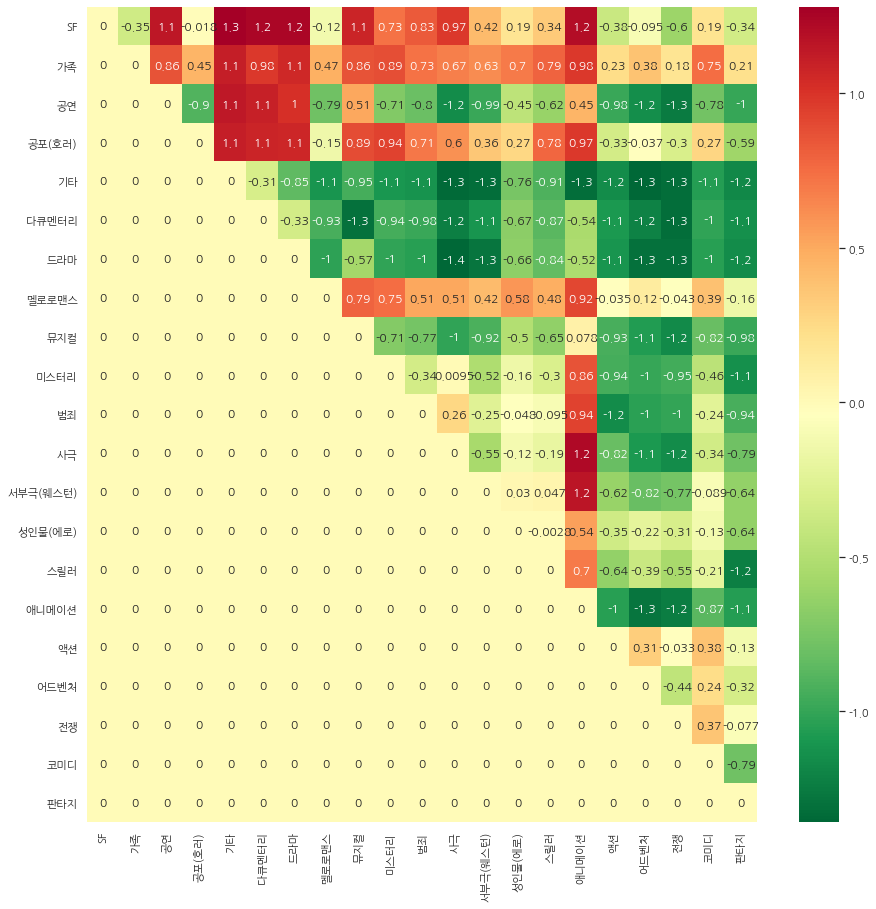

In [32]:
np.random.seed(0)
sns.set(font='NanumGothic')   # 한글 지원 폰트

# 마이너스 부호 
plt.figure(figsize = (15, 15))
plt.rcParams['axes.unicode_minus'] = False


ax = sns.heatmap(
    matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r'
)
plt.show()

<br>

## 6. 결론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; WEAT를 이용하여 21개의 영화 장르에 따른 '예술 영화'와 '일반 영화'에 대한 편향을 측정 하였습니다. 이를 위해 영화 시놉시스 데이터를 바탕으로 Word2Vec 임베딩 벡터를 학습하고 각 축에 따른 대표 단어를 선정하여 편향성 측정을 진행하였습니다.
</span><br><br>
    
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 대표 단어 선정은 TF-IDF 값을 지표로 사용하고 중복 값은 Target의 경우 각 축에서 모두 제외 하였으며, Attribute의 경우 각 축의 TF-IDF 차이가 0.1 이상일 때, TF-IDF가 낮은 축의 중복 단어만 제외 하고 차이가 0.1 미만일 때는 각 축에서 모두 제외 하여 중복 단어를 처리하였습니다. 예술 영화와 일반 영화를 대표하는 단어는 각 10개, 각 장르를 대표하는 단어는 각 5개를 사용 하였습니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; WEAT score는 1 이상을 유의미한 값으로 판단하고 이를 바탕으로 해석하였습니다. [표 1]은 영화 구분과 21개 영화 장르에 대한 편향성 측정 결과를 제시한 것입니다. 앞선 기준을 바탕으로 WEAT score를 해석한 결과, '어드벤처', '전쟁', '판타지' 등의 순으로 예술 영화에 가까운 것으로 확인되었습니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서는 '중복 단어 처리' 방법으로 축 간의 중복 단어의 TF-IDF의 차이를 기준으로 해당 차이에 따라, 하나의 축의 중복 단어만 살리거나 각 축의 중복 단어를 모두 제외하는 새로운 방법을 제시하였습니다. 이를 통해 각 축 간의 중복 단어 문제를 완전하게 해소할 수 있습니다. 
</span><br><br>    
    
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 그러나 이는 Target과 Attribute의 대표 단어 선정 시, 중복 단어를 모두 제외하거나 특정 축의 중복 단어를 제외하여 대부분의 단어가 필터링 되어 대표 단어로 선정되는 단어가 매우 적어진다는 한계가 존재합니다. 본 예제에서도 대부분의 중복 단어가 제외 됨으로써 Target의 대표 단어는 10개, Attribute 대표 단어는 5개로 그 수가 매우 적었습니다. 표본이 적기 때문에 올바른 WEAT score 측정이 이루어지지 않는 문제가 발생할 수 있습니다. 따라서, 이를 방지하기 위해, 데이터 수집, 사용 시에 데이터가 다양한 단어 혹은 명사로 구성되도록 할 필요가 있습니다. 이를 통해 각 축 간의 중복 단어 문제를 완전하게 해소함으로써 발생하는 문제를 해소할 수 있을 것으로 기대합니다.
</span><br><br>


|Rank|장르|예술 영화에 가까운 정도<br>(WEAT score 1. 이상 항목 개수)|
|:--------:|:--------:|:--------:|
|1|어드벤처|9|
|2|전쟁|8|
|3|판타지|7|
|4|SF, 사극|6|
|5|액션|5|
|6|서부극(웨스턴)|4|
|7|공연, 공포(호러), 코미디|3|
|8|가족, 멜로로맨스, 미스터리, 범죄|2|
|9|뮤지컬, 애니메이션|1|
|10|기타, 다큐멘터리, 드라마, 성인물(에로), 스릴러|0|

[표 1] 영화 구분(예술 영화, 일반 영화)과 21개 영화 장르에 대한 편향성 측정 결과

***

#### 참고문헌
***
[1] 이기창, 『한국어 임베딩』, 에이콘(2019).
***

#### 형상관리 기록
***
+ v1_1: 실습 예제 진행


+ v2_1: 제출 예제 진행
***